Let's load the usual packages and the data
- Run `import Pkg; Pkg.add("PrettyPrinting")` to install the PrettyPrinting package.

In [2]:
import Pkg; Pkg.add("PrettyPrinting")

┌ Warning: could not download https://pkg.julialang.org/registries
└ @ Pkg.Types /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Pkg/src/Types.jl:980


In [1]:
using MLJ
import RDatasets: dataset
import DataFrames: DataFrame, describe, select, Not
import StatsBase: countmap, cor, var
using PrettyPrinting

smarket = dataset("ISLR", "Smarket")
@show size(smarket)
@show names(smarket)

size(smarket) = (1250, 9)
names(smarket) = ["Year", "Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume", "Today", "Direction"]


9-element Vector{String}:
 "Year"
 "Lag1"
 "Lag2"
 "Lag3"
 "Lag4"
 "Lag5"
 "Volume"
 "Today"
 "Direction"

Since we often want to only show a few significant digits for the metrics etc, let's introduce a very simple function that does that:


In [2]:
r3 = x -> round(x, sigdigits=3)
r3(pi)

3.14

Let's get a description too

In [3]:
describe(smarket, :mean, :std, :eltype)

,variable,mean,std,eltype
,Symbol,Union…,Union…,DataType
1,Year,2003.02,1.40902,Float64
2,Lag1,0.0038344,1.1363,Float64
3,Lag2,0.0039192,1.13628,Float64
4,Lag3,0.001716,1.1387,Float64
5,Lag4,0.001636,1.13877,Float64
6,Lag5,0.0056096,1.14755,Float64
7,Volume,1.4783,0.360357,Float64
8,Today,0.0031384,1.13633,Float64
9,Direction,,,"CategoricalValue{String, UInt8}"


The target variable is :Direction:

In [4]:
y = smarket.Direction
X = select(smarket, Not(:Direction));

We can compute all the pairwise correlations; we use Matrix so that the dataframe entries are considered as one matrix of numbers with the same type (otherwise cor won't work):

In [5]:
cm = X |> Matrix |> cor
round.(cm, sigdigits=1)

8×8 Matrix{Float64}:
 1.0    0.03    0.03    0.03    0.04    0.03    0.5    0.03
 0.03   1.0    -0.03   -0.01   -0.003  -0.006   0.04  -0.03
 0.03  -0.03    1.0    -0.03   -0.01   -0.004  -0.04  -0.01
 0.03  -0.01   -0.03    1.0    -0.02   -0.02   -0.04  -0.002
 0.04  -0.003  -0.01   -0.02    1.0    -0.03   -0.05  -0.007
 0.03  -0.006  -0.004  -0.02   -0.03    1.0    -0.02  -0.03
 0.5    0.04   -0.04   -0.04   -0.05   -0.02    1.0    0.01
 0.03  -0.03   -0.01   -0.002  -0.007  -0.03    0.01   1.0

#some useful extensions you should add while your at it
- import Pkg; Pkg.add("PlotlyJS")
- import Pkg; Pkg.add("StatPlots")
- import Pkg; Pkg.add("PlotRecipes")
- import Pkg; Pkg.add("coerce")

Let's see plot the :Volume feature and see what it looks like:

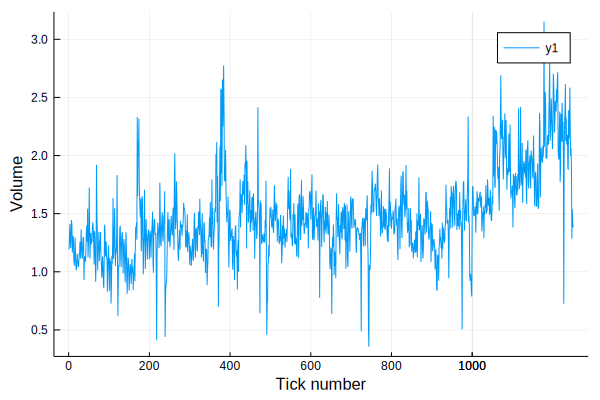

In [51]:
using Plots, PyPlot
PyPlot.figure(figsize=(8,6))
Plots.plot(X.Volume,
    xlabel="Tick number",
    ylabel="Volume")

Logistic Regression
- We will now try to train models; the target :Direction has two classes: Up and Down; 
- it needs to be interpreted as a categorical object, and we will mark it as a ordered factor to specify that 'Up' is positive and 'Down' negative (for the confusion matrix later):

In [15]:
y = coerce(y, OrderedFactor)
classes(y[1])

2-element CategoricalArrays.CategoricalArray{String,1,UInt8}:
 "Down"
 "Up"

Note that in this case the default order comes from the lexicographic order which happens to map to our intuition since D comes before U.


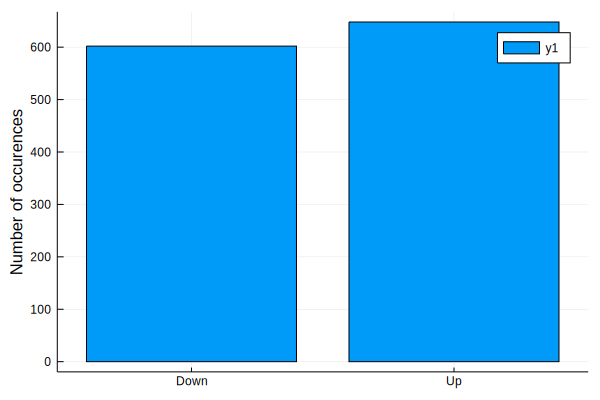

In [52]:
# Packages
import StatsBase: countmap, proportionmap, addcounts!
using Plots, PyPlot

PyPlot.figure(figsize=(8,6))
cm = countmap(y)
Plots.bar([1, 2], [cm["Down"], cm["Up"]],
    xticks=([1, 2], ["Down", "Up"]),
    ylabel="Number of occurences")

Classes seems pretty balanced.

- Let's now try fitting a simple logistic classifier (aka logistic regression) not using :Year and :Today:


In [29]:
import Pkg; Pkg.add("MLJScikitLearnInterface")

In [31]:
using Pkg
Pkg.add("MLJLinearModels")
@load LogisticClassifier pkg=MLJLinearModels

import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/h62343la/.julia/packages/MLJModels/Ppopl/src/loading.jl:168


MLJLinearModels.LogisticClassifier

In [33]:
X2 = select(X, Not([:Year, :Today]))
clf = machine(MLJLinearModels.LogisticClassifier(), X2, y)

Machine{LogisticClassifier,…} @144 trained 0 times; caches data
  args: 
    1:	Source @915 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @275 ⏎ `AbstractVector{OrderedFactor{2}}`


Let's fit it to the data and try to reproduce the output:



In [37]:
using MLJLinearModels
MLJ.fit!(clf)
ŷ = MLJ.predict(clf, X2)
ŷ[1:3]

┌ Info: Training Machine{LogisticClassifier,…} @144.
└ @ MLJBase /Users/h62343la/.julia/packages/MLJBase/diSrF/src/machines.jl:354


3-element MLJBase.UnivariateFiniteVector{OrderedFactor{2}, String, UInt8, Float64}:
 UnivariateFinite{OrderedFactor{2}}(Down=>0.493, Up=>0.507)
 UnivariateFinite{OrderedFactor{2}}(Down=>0.518, Up=>0.482)
 UnivariateFinite{OrderedFactor{2}}(Down=>0.519, Up=>0.481)

Note that here the ŷ are scores. We can recover the average cross-entropy loss:



In [38]:
cross_entropy(ŷ, y) |> mean |> r3

0.691

in order to recover the class, we could use the mode and compare the misclassification rate:

In [39]:
ŷ = predict_mode(clf, X2)
misclassification_rate(ŷ, y) |> r3

0.479

Well that's not fantastic...

- Let's visualise how we're doing building a confusion matrix, first is predicted, second is truth:

In [40]:
cm = confusion_matrix(ŷ, y)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │    Down     │     Up      │
├─────────────┼─────────────┼─────────────┤
│    Down     │     144     │     141     │
├─────────────┼─────────────┼─────────────┤
│     Up      │     458     │     507     │
└─────────────┴─────────────┴─────────────┘


We can then compute the accuracy or precision, etc. easily for instance:


In [41]:
@show false_positive(cm)
@show accuracy(ŷ, y)  |> r3
@show accuracy(cm)    |> r3  # same thing
@show precision(ŷ, y) |> r3
@show recall(ŷ, y)    |> r3
@show f1score(ŷ, y)   |> r3

false_positive(cm) = 458
accuracy(ŷ, y) |> r3 = 0.521
accuracy(cm) |> r3 = 0.521
precision(ŷ, y) |> r3 = 0.525
recall(ŷ, y) |> r3 = 0.782
f1score(ŷ, y) |> r3 = 0.629


0.629

Let's now train on the data before 2005 and use it to predict on the rest. Let's find the row indices for which the condition holds

In [42]:
train = 1:findlast(X.Year .< 2005)
test = last(train)+1:length(y);

We can now just re-fit the machine that we've already defined just on those rows and predict on the test:

In [45]:
MLJ.fit!(clf, rows=train)
ŷ = predict_mode(clf, rows=test)
accuracy(ŷ, y[test]) |> r3

┌ Info: Training Machine{LogisticClassifier,…} @144.
└ @ MLJBase /Users/h62343la/.julia/packages/MLJBase/diSrF/src/machines.jl:354


0.484

Well, that's not very good... Let's retrain a machine using only :Lag1 and :Lag2:



In [47]:
X3 = select(X2, [:Lag1, :Lag2])
clf = machine(MLJLinearModels.LogisticClassifier(), X3, y)

MLJ.fit!(clf, rows=train)
ŷ = predict_mode(clf, rows=test)
accuracy(ŷ, y[test]) |> r3

┌ Info: Training Machine{LogisticClassifier,…} @803.
└ @ MLJBase /Users/h62343la/.julia/packages/MLJBase/diSrF/src/machines.jl:354


0.56

Let us use the trained model to predict on new data:

In [48]:
Xnew = (Lag1 = [1.2, 1.5], Lag2 = [1.1, -0.8])
ŷ = MLJ.predict(clf, Xnew)
ŷ |> pprint

UnivariateFinite{OrderedFactor{2}, String, UInt8, Float64}[UnivariateFinite{OrderedFactor{2}}(Down=>0.521, Up=>0.479), UnivariateFinite{OrderedFactor{2}}(Down=>0.504, Up=>0.496)]

In [49]:
mode.(ŷ)

2-element CategoricalArrays.CategoricalArray{String,1,UInt8}:
 "Down"
 "Down"

# LDA


- Let's do a similar thing but with a LDA model this time:

In [54]:
import Pkg; Pkg.add("MLJMultivariateStatsInterface")

In [56]:
using Pkg
Pkg.add("MultivariateStats")

@load BayesianLDA pkg=MultivariateStats

import MLJMultivariateStatsInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/h62343la/.julia/packages/MLJModels/Ppopl/src/loading.jl:168


MLJMultivariateStatsInterface.BayesianLDA

In [63]:
clfB = machine(MLJMultivariateStatsInterface.BayesianLDA(), X3, y)
fit!(clfB, rows=train)
ŷ = predict_mode(clfB, rows=test)

accuracy(ŷ, y[test]) |> r3

LoadError: UndefVarError: fit! not defined